<a href="https://colab.research.google.com/github/ascle/colab_tcc2/blob/dev/5_modelagem-classificacao_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importando bibliotecas<hr style='border: 2px solid red;'>


In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

### Outras configurações<hr style='border: 2px solid red;'>



In [3]:
!pip install ipython-autotime
pd.set_option('display.max_columns', None)
%load_ext autotime

SEED = 7
np.random.seed(SEED)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.6 MB/s eta 0:00:00
time: 703 µs (started: 2023-08-25 18:30:44 +00:00)


### Conectando no ambiente que será utilizado<hr style='border: 2px solid red;'>


In [4]:
# Importando do Drive
from google.colab import drive
from os import chdir

drive.mount('/content/drive', force_remount=True)
chdir('/content/drive/MyDrive/UFS/tcc-2-ascle-ufs/bases/linkage_marco/')

Mounted at /content/drive
time: 21.6 s (started: 2023-08-25 18:30:44 +00:00)


#### Leitura dos dados

In [5]:
data_raw = pd.read_csv('dn_etl.csv', sep=';', low_memory=False)
data_raw.sort_index(axis=1, inplace=True)

time: 1.74 s (started: 2023-08-25 18:31:06 +00:00)


In [6]:
data_raw.shape

(190020, 24)

time: 6.25 ms (started: 2023-08-25 18:31:08 +00:00)


In [7]:
data_raw.head()

,ANO,APGAR1,APGAR5,CODANOMAL_QTD,CONSPRENAT,ESCMAEETL_VALOR,ESTCIVMAE_COMPANHEIRO,GRAVIDEZ_VALOR,LOCNASC_DOMICILIO,LOCNASC_ESTAB_SAUDE,LOCNASC_HOSPITAL,LOCNASC_OUTROS,OBT_NEONATAL,PARTO_CESAREO,PARTO_VAGINALL,PESO,QTDFILMORT,QTDPARTCES,SEMAGESTAC,SEXO_FEM,SEXO_MASC,TPAPRESENT_CEFALICO,TPAPRESENT_PELVICO,TPAPRESENT_TRANSVERSA
0,2015,2.0,4.0,0.0,5.0,1,0,1,0,0,1,0,0,1,0,820.0,1.0,NaN,26.0,0,1,1,0,0
1,2015,9.0,10.0,0.0,8.0,4,1,1,0,0,1,0,0,1,0,4200.0,1.0,NaN,39.0,0,1,1,0,0
2,2015,7.0,8.0,0.0,10.0,11,1,1,0,0,1,0,0,0,1,3700.0,0.0,0.0,40.0,1,0,1,0,0
3,2015,7.0,8.0,0.0,7.0,4,0,1,0,0,1,0,0,0,1,3550.0,1.0,0.0,37.0,0,1,1,0,0
4,2015,9.0,10.0,0.0,3.0,11,0,1,0,0,1,0,0,1,0,3800.0,0.0,NaN,39.0,1,0,1,0,0


time: 26.9 ms (started: 2023-08-25 18:31:08 +00:00)


## Dados X e y<hr style='border: 2px solid red;'>

In [8]:
X_raw= data_raw.drop(columns=['QTDPARTCES', 'ANO', 'OBT_NEONATAL'])
y_raw= data_raw["OBT_NEONATAL"]

time: 20 ms (started: 2023-08-25 18:31:08 +00:00)


## Dados desbalanceados<hr style='border: 2px solid red;'>

https://imbalanced-learn.org/stable/introduction.html

https://medium.com/data-hackers/como-lidar-com-dados-desbalanceados-em-problemas-de-classifica%C3%A7%C3%A3o-17c4d4357ef9

https://medium.com/turing-talks/dados-desbalanceados-o-que-s%C3%A3o-e-como-evit%C3%A1-los-43df4f49732b

https://www.teses.usp.br/teses/disponiveis/55/55134/tde-06012016-145045/publico/VictorHugoBarella_dissertacao_revisada.pdf

https://www.hashtagtreinamentos.com/datasets-desbalanceados-ciencia-dados


In [9]:
from imblearn.over_sampling import SMOTE

time: 423 ms (started: 2023-08-25 18:31:08 +00:00)


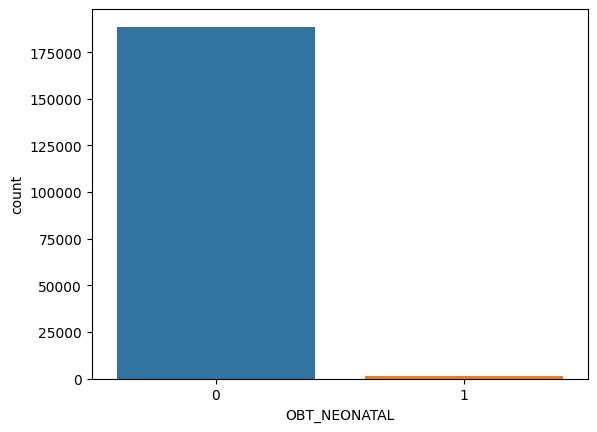

time: 280 ms (started: 2023-08-25 18:31:08 +00:00)


In [10]:
ax = sns.countplot(x='OBT_NEONATAL', data=data_raw)

#### Oversampling Smote

https://arxiv.org/abs/1106.1813

Consiste em criar observações intermediárias entre dados parecidos

In [11]:
smt = SMOTE(random_state=SEED)
X_bal, y_bal = smt.fit_resample(X_raw, y_raw)

time: 601 ms (started: 2023-08-25 18:31:09 +00:00)


In [12]:
data_bal = pd.concat([X_bal, y_bal], axis=1)

time: 49.6 ms (started: 2023-08-25 18:31:09 +00:00)


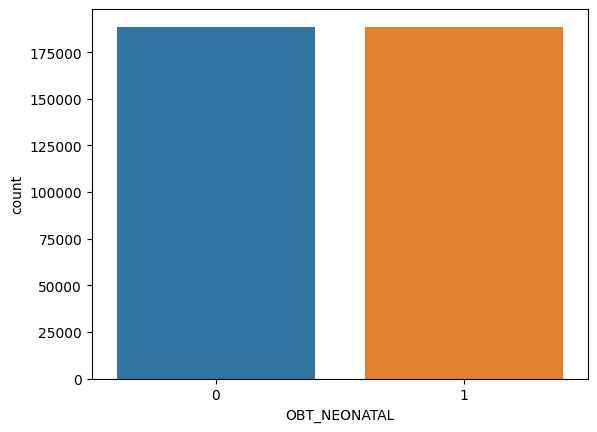

time: 210 ms (started: 2023-08-25 18:31:09 +00:00)


In [13]:
ax = sns.countplot(x='OBT_NEONATAL', data=data_bal)

##Dados de treino e de teste<hr style='border: 2px solid red;'>

In [14]:
from sklearn.model_selection import train_test_split

time: 379 µs (started: 2023-08-25 18:31:09 +00:00)


In [15]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X_bal, y_bal, test_size =0.3,
                                                        random_state=SEED,
                                                        stratify=y_bal)
print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(X_treino), len(X_teste)))
print()

Treinaremos com 264068 elementos e testaremos com 113172 elementos

time: 237 ms (started: 2023-08-25 18:31:09 +00:00)


### Base de treino normalizada

In [16]:
from sklearn.preprocessing import StandardScaler

time: 433 µs (started: 2023-08-25 18:31:10 +00:00)


In [17]:
scaler = scaler = StandardScaler()
scaler.fit(X_treino)
X_treino_norm = scaler.transform(X_treino)
X_teste_norm = scaler.transform(X_teste)

time: 131 ms (started: 2023-08-25 18:31:10 +00:00)


<font color="red">*Dados categóricos???*</font>

### Métodos auxiliares

In [18]:
def imprimir_metricas(_nome_modelo, _predito):
  print("A Acurácia do modelo {} foi {:.2f}%".format(_nome_modelo, (accuracy_score(y_teste, _predito) * 100)))
  print("A Precisão do modelo {} foi {:.2f}%".format(_nome_modelo, (precision_score(y_teste, _predito) * 100)))
  print("A Recall do modelo {} foi {:.2f}%".format(_nome_modelo, (recall_score(y_teste, _predito) * 100)))
  print("A F1 do modelo {} foi {:.2f}%".format(_nome_modelo, (f1_score(y_teste, _predito) * 100)))
  print()

time: 902 µs (started: 2023-08-25 18:31:10 +00:00)


In [19]:
def imprime_metrica_cv(_nome_modelo, _results):
    media = _results['test_score'].mean()
    desvio_padrao = _results['test_score'].std()
    ini = (media - 2 * desvio_padrao)*100
    fim = (media + 2 * desvio_padrao) * 100
    print("A Acurácia do modelo {} com Cross Validation foi  [{:.2f}%, {:.2f}%]".format(_nome_modelo, ini, fim))
    print()

time: 841 µs (started: 2023-08-25 18:31:10 +00:00)


### <font style='font-size: 30px;'>Dummy Classifier Stratified</font>
<hr style='border: 2px solid red;'>

In [20]:
from sklearn.dummy import DummyClassifier

time: 476 µs (started: 2023-08-25 18:31:10 +00:00)


In [21]:
modelo_dummy_stratified = DummyClassifier(strategy='stratified')
modelo_dummy_stratified.fit(X_treino, y_treino)
predito_ds = modelo_dummy_stratified.predict(X_teste)

imprimir_metricas('Dummy Stratified', predito_ds)
print()

A Acurácia do modelo Dummy Stratified foi 49.87%
A Precisão do modelo Dummy Stratified foi 49.87%
A Recall do modelo Dummy Stratified foi 49.90%
A F1 do modelo Dummy Stratified foi 49.88%


time: 187 ms (started: 2023-08-25 18:31:10 +00:00)


### <font style='font-size: 30px;'>Dummy Classifier Most Frequence</font>
<hr style='border: 2px solid red;'>

In [22]:
modelo_dummy_mostfrequent = DummyClassifier(strategy="most_frequent")
modelo_dummy_mostfrequent.fit(X_treino, y_treino)
predito_dmf = modelo_dummy_mostfrequent.predict(X_teste)

imprimir_metricas('Dummy Most Frequent', predito_dmf)

A Acurácia do modelo Dummy Most Frequent foi 50.00%
A Precisão do modelo Dummy Most Frequent foi 0.00%
A Recall do modelo Dummy Most Frequent foi 0.00%
A F1 do modelo Dummy Most Frequent foi 0.00%

time: 163 ms (started: 2023-08-25 18:31:10 +00:00)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### <font style='font-size: 30px;'>Modelo SVC</font>
<hr style='border: 2px solid red;'>

In [23]:
from sklearn.svm import SVC

time: 522 µs (started: 2023-08-25 18:31:10 +00:00)


In [24]:
modelo_svc = SVC(gamma='auto', random_state = SEED)
modelo_svc.fit(X_treino_norm, y_treino)
predito_svc = modelo_svc.predict(X_teste_norm)

imprimir_metricas('SVC', predito_svc)

A Acurácia do modelo SVC foi 97.88%
A Precisão do modelo SVC foi 98.70%
A Recall do modelo SVC foi 97.04%
A F1 do modelo SVC foi 97.87%

time: 11min (started: 2023-08-25 18:31:10 +00:00)


### <font style='font-size: 30px;'>KNN</font>
<hr style='border: 2px solid red;'>

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.DistanceMetric.html#sklearn.metrics.DistanceMetric

<font color="red">*Dados categóricos???*</font>

In [25]:
from sklearn.neighbors import KNeighborsClassifier

time: 485 µs (started: 2023-08-25 18:42:11 +00:00)


In [26]:
modelo_knn_euc = KNeighborsClassifier(metric='euclidean')
modelo_knn_euc.fit(X_treino_norm, y_treino)
predito_knn_euc = modelo_knn_euc.predict(X_teste_norm)

imprimir_metricas('KNN Euclidean', predito_knn_euc)

A Acurácia do modelo KNN Euclidean foi 99.30%
A Precisão do modelo KNN Euclidean foi 98.89%
A Recall do modelo KNN Euclidean foi 99.72%
A F1 do modelo KNN Euclidean foi 99.30%

time: 3min 7s (started: 2023-08-25 18:42:11 +00:00)


In [27]:
modelo_knn_man = KNeighborsClassifier(metric='manhattan')
modelo_knn_man.fit(X_treino_norm, y_treino)
predito_knn_man = modelo_knn_man.predict(X_teste_norm)

imprimir_metricas('KNN Manhattan', predito_knn_man)

A Acurácia do modelo KNN Manhattan foi 99.52%
A Precisão do modelo KNN Manhattan foi 99.30%
A Recall do modelo KNN Manhattan foi 99.75%
A F1 do modelo KNN Manhattan foi 99.52%

time: 17min 58s (started: 2023-08-25 18:45:18 +00:00)


In [28]:
modelo_knn_mi = KNeighborsClassifier(metric='minkowski')
modelo_knn_mi.fit(X_treino_norm, y_treino)
predito_knn_mi = modelo_knn_mi.predict(X_teste_norm)

imprimir_metricas('KNN Minkowski', predito_knn_mi)

A Acurácia do modelo KNN Minkowski foi 99.30%
A Precisão do modelo KNN Minkowski foi 98.89%
A Recall do modelo KNN Minkowski foi 99.72%
A F1 do modelo KNN Minkowski foi 99.30%

time: 3min 5s (started: 2023-08-25 19:03:17 +00:00)


In [29]:
modelo_knn_ch = KNeighborsClassifier(metric='chebyshev')
modelo_knn_ch.fit(X_treino_norm, y_treino)
predito_knn_ch = modelo_knn_ch.predict(X_teste_norm)

imprimir_metricas('KNN Chebyshev', predito_knn_ch)

A Acurácia do modelo KNN Chebyshev foi 98.98%
A Precisão do modelo KNN Chebyshev foi 98.32%
A Recall do modelo KNN Chebyshev foi 99.66%
A F1 do modelo KNN Chebyshev foi 98.99%

time: 14min 36s (started: 2023-08-25 19:06:22 +00:00)


### <font style='font-size: 30px;'>Árvore de decisão</font>
<hr style='border: 2px solid red;'>

<font color="red">*Definir profundidade*</font>

In [30]:
from sklearn.tree import DecisionTreeClassifier

time: 737 µs (started: 2023-08-25 19:20:58 +00:00)


In [31]:
modelo_dtc = DecisionTreeClassifier()
modelo_dtc.fit(X_treino, y_treino)
predito_dtc = modelo_dtc.predict(X_teste)

imprimir_metricas('Decision Tree', predito_dtc)

A Acurácia do modelo Decision Tree foi 99.49%
A Precisão do modelo Decision Tree foi 99.41%
A Recall do modelo Decision Tree foi 99.57%
A F1 do modelo Decision Tree foi 99.49%

time: 2.44 s (started: 2023-08-25 19:20:58 +00:00)


### <font style='font-size: 30px;'>Árvore de Decisão Cross Validate</font>
<hr style='border: 2px solid red;'>

In [32]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

time: 433 µs (started: 2023-08-25 19:21:01 +00:00)


In [33]:
cv = StratifiedKFold(n_splits = 10, shuffle=True)
modelo_dtc_cv = DecisionTreeClassifier()
results = cross_validate(modelo_dtc_cv, X_treino, y_treino, cv = cv, return_train_score=False)

imprime_metrica_cv('Decision Tree', results)

A Acurácia do modelo Decision Tree com Cross Validation foi  [99.41%, 99.58%]

time: 22.9 s (started: 2023-08-25 19:21:01 +00:00)


### <font style='font-size: 30px;'>Random Forest</font>
<hr style='border: 2px solid red;'>

<font color="red">*Definir estimadores*</font>

In [34]:
from sklearn.ensemble import RandomForestClassifier

time: 478 µs (started: 2023-08-25 19:21:24 +00:00)


In [35]:
modelo_rfc = RandomForestClassifier(n_estimators = 100)
modelo_rfc.fit(X_treino, y_treino)
predito_rfc = modelo_rfc.predict(X_teste)

imprimir_metricas('Random Forest', predito_rfc)
print()

A Acurácia do modelo Random Forest foi 99.73%
A Precisão do modelo Random Forest foi 99.83%
A Recall do modelo Random Forest foi 99.64%
A F1 do modelo Random Forest foi 99.73%


time: 38 s (started: 2023-08-25 19:21:24 +00:00)


### <font style='font-size: 30px;'>Random Forest Cross Validate</font>
<hr style='border: 2px solid red;'>

In [36]:
cv_rf = StratifiedKFold(n_splits = 10, shuffle=True)
modelo_rf_cv = RandomForestClassifier(n_estimators = 100)
results = cross_validate(modelo_rf_cv, X_treino, y_treino, cv = cv_rf, return_train_score=False)

imprime_metrica_cv('Random Forest', results)

A Acurácia do modelo Random Forest com Cross Validation foi  [99.70%, 99.77%]

time: 5min 30s (started: 2023-08-25 19:22:02 +00:00)


## Validando modelos<hr style='border: 2px solid red;'>

https://medium.com/turing-talks/como-avaliar-seu-modelo-de-classifica%C3%A7%C3%A3o-acd2a03690e



### Matriz de Confusão

In [37]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

time: 586 µs (started: 2023-08-25 19:27:32 +00:00)


[Text(0.5, 1.0, 'Mostfrequent')]

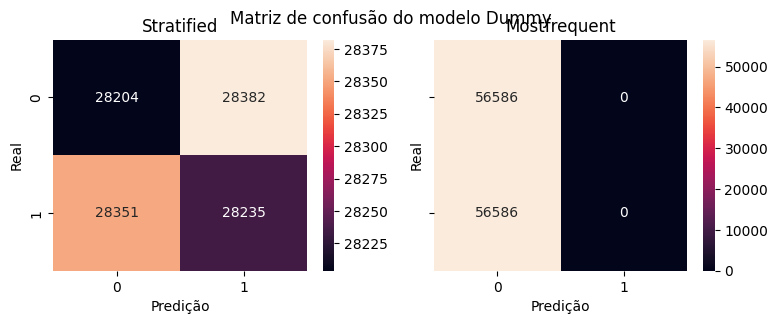

time: 642 ms (started: 2023-08-25 19:27:32 +00:00)


In [38]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
fig.suptitle('Matriz de confusão do modelo Dummy')

sns.heatmap(data=confusion_matrix(y_teste, predito_ds), annot = True, fmt = "d", ax=axes[0])
axes[0].set(xlabel = "Predição", ylabel = "Real")
axes[0].set(title='Stratified')

sns.heatmap(confusion_matrix(y_teste, predito_dmf), annot = True, fmt = "d", ax=axes[1])
axes[1].set(xlabel = "Predição", ylabel = "Real")
axes[1].set(title='Mostfrequent')

In [39]:
#from yellowbrick.classifier.rocauc import roc_auc

#plt.figure(figsize=(9,3))
#plt.title("Curva Roc para o modelo RandomForest")
#roc_auc(modelo_dummy_stratified, X_treino, y_treino, X_test=X_teste, y_test=y_teste)

time: 331 µs (started: 2023-08-25 19:27:33 +00:00)


[Text(0.5, 1.0, 'Mostfrequent')]

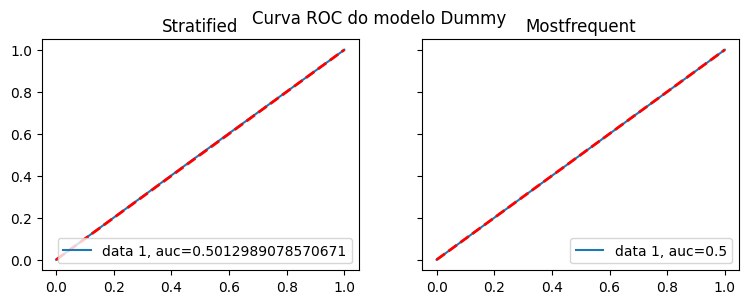

time: 732 ms (started: 2023-08-25 19:27:33 +00:00)


In [40]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
fig.suptitle('Curva ROC do modelo Dummy')

y_pred_proba =  modelo_dummy_stratified.predict_proba(X_teste)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_teste,  y_pred_proba)
auc = metrics.roc_auc_score(y_teste, y_pred_proba)
axes[0].plot(fpr,tpr,label="data 1, auc="+str(auc))
axes[0].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
axes[0].legend(loc=4)
axes[0].set(title='Stratified')

y_pred_proba =  modelo_dummy_mostfrequent.predict_proba(X_teste)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_teste,  y_pred_proba)
auc = metrics.roc_auc_score(y_teste, y_pred_proba)
axes[1].plot(fpr,tpr,label="data 1, auc="+str(auc))
axes[1].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
axes[1].legend(loc=4)
axes[1].set(title='Mostfrequent')

[Text(0.5, 1.0, 'Matriz de confusão')]

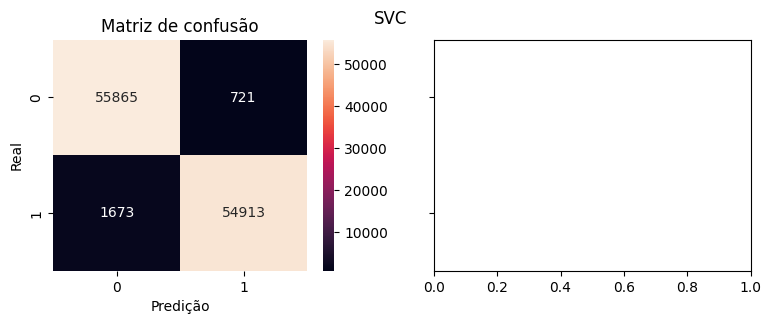

time: 593 ms (started: 2023-08-25 19:27:34 +00:00)


In [41]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
fig.suptitle('SVC')

sns.heatmap(data=confusion_matrix(y_teste, predito_svc), annot = True, fmt = "d", ax=axes[0])
axes[0].set(xlabel = "Predição", ylabel = "Real")
axes[0].set(title='Matriz de confusão')

#y_pred_proba =  modelo_svc.predict_proba(X_teste_norm)[::,1]
#fpr, tpr, _ = metrics.roc_curve(y_teste,  y_pred_proba)
#auc = metrics.roc_auc_score(y_teste, y_pred_proba)
#axes[1].plot(fpr,tpr,label="data 1, auc="+str(auc))
#axes[1].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
#axes[1].legend(loc=4)
#axes[1].set(title='Curva ROC')


[Text(0.5, 1.0, 'Chebyshev')]

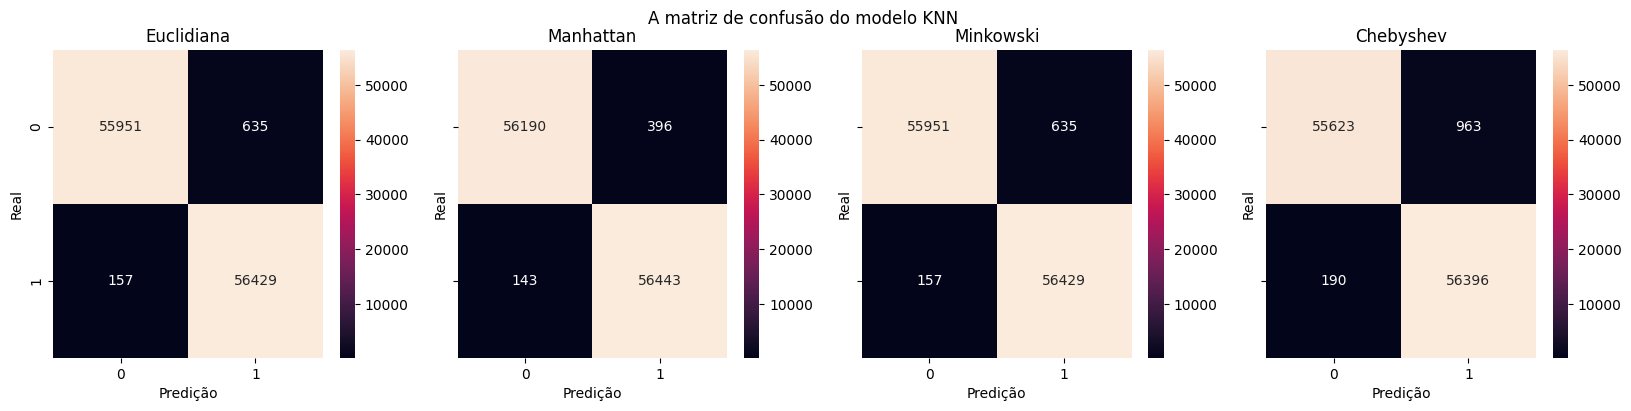

time: 1.89 s (started: 2023-08-25 19:27:34 +00:00)


In [42]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4), sharey=True)
fig.suptitle('A matriz de confusão do modelo KNN')

sns.heatmap(data=confusion_matrix(y_teste, predito_knn_euc), annot = True, fmt = "d", ax=axes[0])
axes[0].set(xlabel = "Predição", ylabel = "Real")
axes[0].set(title='Euclidiana')

sns.heatmap(data=confusion_matrix(y_teste, predito_knn_man), annot = True, fmt = "d", ax=axes[1])
axes[1].set(xlabel = "Predição", ylabel = "Real")
axes[1].set(title='Manhattan')

sns.heatmap(data=confusion_matrix(y_teste, predito_knn_mi), annot = True, fmt = "d", ax=axes[2])
axes[2].set(xlabel = "Predição", ylabel = "Real")
axes[2].set(title='Minkowski')

sns.heatmap(data=confusion_matrix(y_teste, predito_knn_ch), annot = True, fmt = "d", ax=axes[3])
axes[3].set(xlabel = "Predição", ylabel = "Real")
axes[3].set(title='Chebyshev')

[Text(0.5, 1.0, 'Chebyshev')]

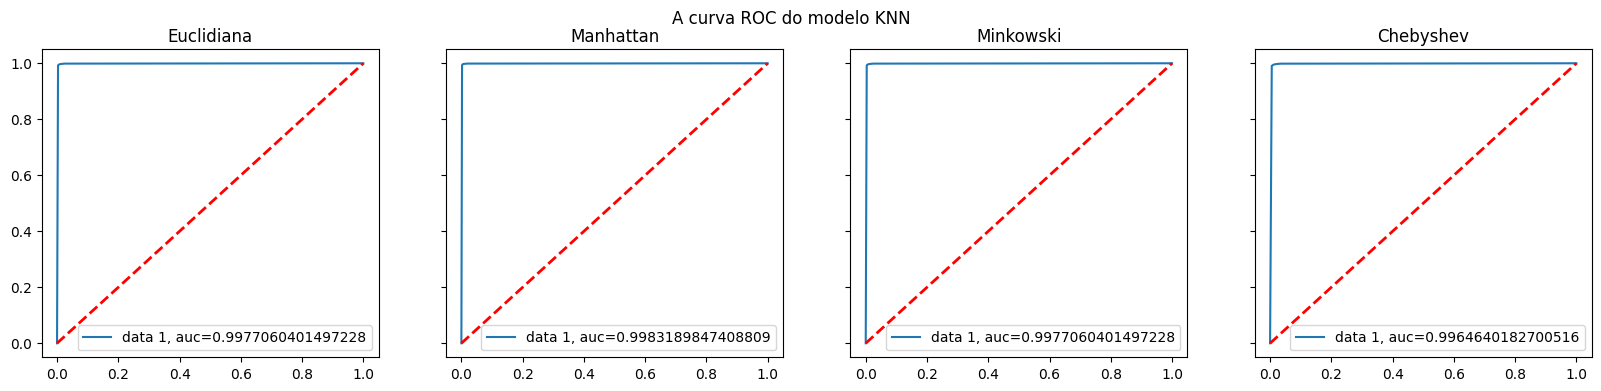

time: 38min 49s (started: 2023-08-25 19:27:36 +00:00)


In [43]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4), sharey=True)
fig.suptitle('A curva ROC do modelo KNN')

y_pred_proba =  modelo_knn_euc.predict_proba(X_teste_norm)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_teste,  y_pred_proba)
auc = metrics.roc_auc_score(y_teste, y_pred_proba)
axes[0].plot(fpr,tpr,label="data 1, auc="+str(auc))
axes[0].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
axes[0].legend(loc=4)
axes[0].set(title='Euclidiana')

y_pred_proba =  modelo_knn_man.predict_proba(X_teste_norm)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_teste,  y_pred_proba)
auc = metrics.roc_auc_score(y_teste, y_pred_proba)
axes[1].plot(fpr,tpr,label="data 1, auc="+str(auc))
axes[1].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
axes[1].legend(loc=4)
axes[1].set(title='Manhattan')

y_pred_proba =  modelo_knn_mi.predict_proba(X_teste_norm)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_teste,  y_pred_proba)
auc = metrics.roc_auc_score(y_teste, y_pred_proba)
axes[2].plot(fpr,tpr,label="data 1, auc="+str(auc))
axes[2].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
axes[2].legend(loc=4)
axes[2].set(title='Minkowski')

y_pred_proba =  modelo_knn_ch.predict_proba(X_teste_norm)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_teste,  y_pred_proba)
auc = metrics.roc_auc_score(y_teste, y_pred_proba)
axes[3].plot(fpr,tpr,label="data 1, auc="+str(auc))
axes[3].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
axes[3].legend(loc=4)
axes[3].set(title='Chebyshev')

[Text(0.5, 1.0, 'Random Forest')]

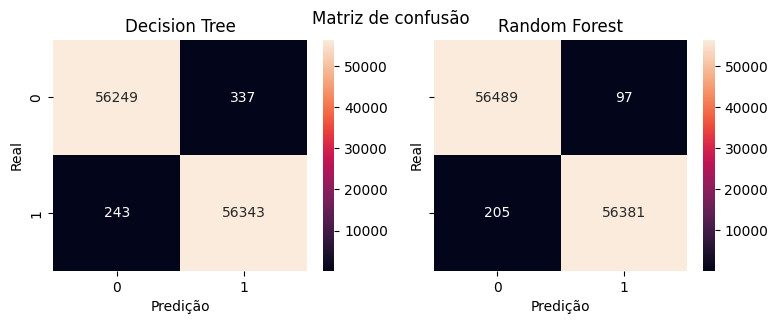

time: 619 ms (started: 2023-08-25 20:06:26 +00:00)


In [44]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
fig.suptitle('Matriz de confusão')

ax = sns.heatmap(confusion_matrix(y_teste, predito_dtc), annot = True, fmt = "d", ax=axes[0])
ax.set(xlabel = "Predição", ylabel = "Real")
ax.set(title='Decision Tree')

sns.heatmap(confusion_matrix(y_teste, predito_rfc), annot = True, fmt = "d", ax=axes[1])
axes[1].set(xlabel = "Predição", ylabel = "Real")
axes[1].set(title='Random Forest')

[Text(0.5, 1.0, 'Manhattan')]

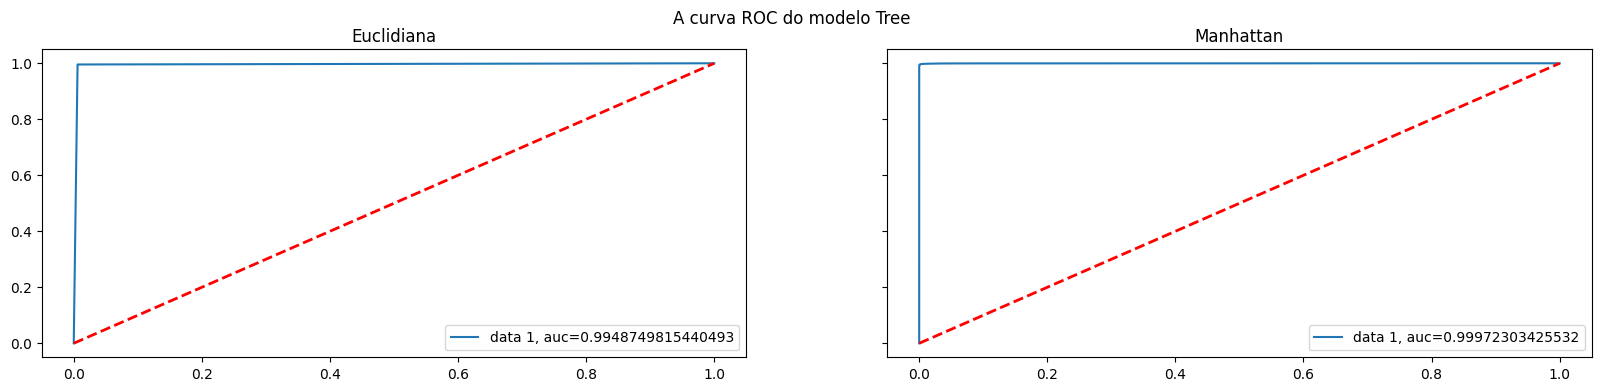

time: 3.01 s (started: 2023-08-25 20:06:27 +00:00)


In [45]:
fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharey=True)
fig.suptitle('A curva ROC do modelo Tree')

y_pred_proba =  modelo_dtc.predict_proba(X_teste)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_teste,  y_pred_proba)
auc = metrics.roc_auc_score(y_teste, y_pred_proba)
axes[0].plot(fpr,tpr,label="data 1, auc="+str(auc))
axes[0].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
axes[0].legend(loc=4)
axes[0].set(title='Euclidiana')

y_pred_proba =  modelo_rfc.predict_proba(X_teste)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_teste,  y_pred_proba)
auc = metrics.roc_auc_score(y_teste, y_pred_proba)
axes[1].plot(fpr,tpr,label="data 1, auc="+str(auc))
axes[1].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
axes[1].legend(loc=4)
axes[1].set(title='Manhattan')

## Escolhendo o melhor modelo<hr style='border: 2px solid red;'>

**Métrica escolhida:**

**Random Forest**

Acurácia: 99.74%

Precisão: 99.81%

Recall: 99.67% < knn

F1: 99.74%

time: 3.02 s (started: 2023-08-25 20:06:27 +00:00)
